# H&M Personalised Fashion Recommender

Part 1: Exploratory Data Analysis <br>
**Part 2: Content-Based Filtering Recommender** <br>
Part 3: Collaborative Filtering Recommender  <br>
Part 4: Model Deployment <br>

## Import Libraries and Dataset

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display progress bar
from tqdm import tqdm
tqdm.pandas()

# For reading images
from PIL import Image

# For embeddings generation
from sentence_transformers import SentenceTransformer

# For similairty score
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [4]:
image_data = pd.read_csv('../datasets/image_data.csv')
print(image_data.shape)
image_data.head()

(20756, 3)


,img_path,article_id,detail_desc
0,../datasets/images/0654410024.jpg,654410024,Short-sleeved polo shirt in cotton piqué with ...
1,../datasets/images/0841228001.jpg,841228001,Straight-cut T-shirt in soft cotton jersey wit...
2,../datasets/images/0633740001.jpg,633740001,Jumper in a soft rib knit with long sleeves.
3,../datasets/images/0651461003.jpg,651461003,Long-sleeved jumper in a soft waffle-knit cott...
4,../datasets/images/0525831010.jpg,525831010,"Round-necked, long-sleeved top in stretch, cot..."


## Content-Based Filtering
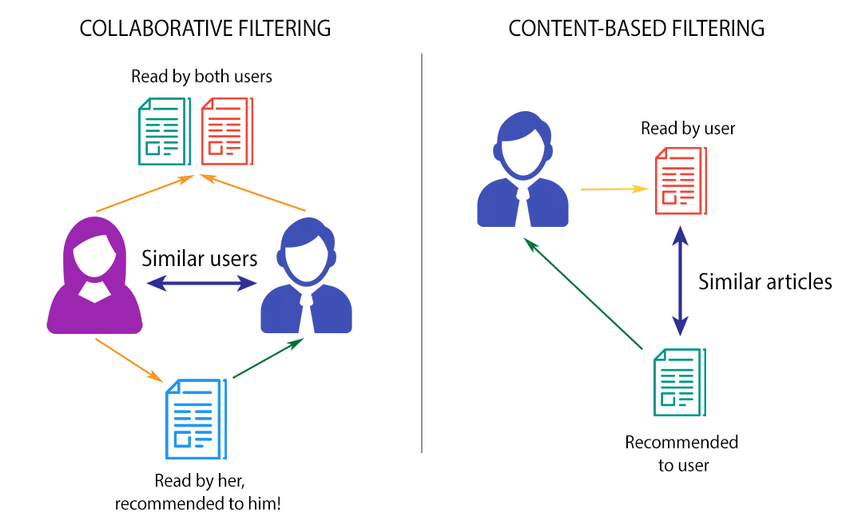

1) **Content-based filtering: Find features of an item and recommend items with similar features** (covered in this notebook)
2) Collaborative filtering: Recommend items based on people with similar interests.

## Generate Embeddings with Contrastive Language-Image Pre-Training (CLIP) Model

The features of products will be extracted from images. In order to do so, images need to be converted to embedding vectors. One way of generating embeddings for image is Contrastive Language-Image Pre-Training (CLIP).

**What is Contrastive Language-Image Pre-Training (CLIP)?** <br>
Contrastive Language-Image Pre-Training (CLIP) is a state-of-the-art computer vision system that maps texts and images into the same shared vector space ([Radford et al., 2021](https://arxiv.org/abs/2103.00020)). The benefit of doing so is that it allows for multi-modal similarity search (for example, text-to-image, image-to-image).

**How does CLIP work?** <br>
CLIP uses convolutional neural networks pre-trained with Simple framework for Contrastive Learning of Visual Representations. More simply put, the embeddings are generated in a way that preserves the objects’ similarity — similar objects get closer to each other and dissimilar objects get further apart.

In the contrastive learning model, each source image has its corresponding text description, which forms a text-image pair. The images are passed through a ResNet or a ViT encoder to generate the image embeddings. The text descriptions are passed through a Transformer based encoder to generate text embeddings. The embeddings would be in the same shared vector space.

The generated embeddings are evaluated using contrastive loss function. The objective is to minimise the distance between the text-image pair, and maximise the 
distance between the source image and dissimilar images.

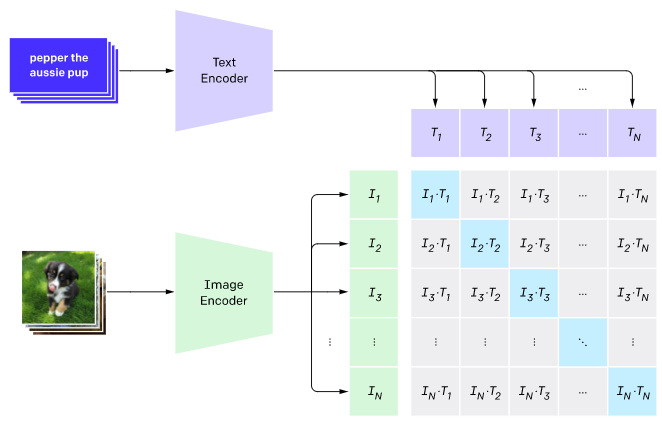<br>
source of image: [openai](https://openai.com/blog/clip/)

Reference: https://towardsdatascience.com/powering-semantic-similarity-search-in-computer-vision-with-state-of-the-art-embeddings-f6c183fff134

In [9]:
# Load the CLIP model using Sentence Transformer
clip_model = SentenceTransformer('clip-ViT-B-32')

In [6]:
# Initialize an empty list for embeddings
clip_embeddings = []

In [7]:
# Load the images from image path
images = []

for img_path in tqdm(image_data['img_path'],position=0,leave=False):
    images.append(Image.open(img_path).reduce(4))

In [14]:
# Generate CLIP embeddings for the loaded images
clip_embeddings.extend(clip_model.encode(images, show_progress_bar=True).tolist())

In [ ]:
# Assign the embeddings back to the dataframe
image_data['clip_embedding'] = clip_embeddings

In [ ]:
# Save the embeddings
image_data.to_pickle('../datasets/image_embeddings.pkl')

### Content-Based Filtering

In [27]:
# Define a recommender that receives text input
def text_query_recommender(df,text_query,number_of_recommendations):
    
    # Encode the text using CLIP
    text_emb = clip_model.encode([text_query])
    
    # Calculate cosine similarities for queried product
    similarities = cosine_similarity(text_emb,image_data['clip_embedding'].values.tolist())[0]
    
    # Sort cosine similarities in descending order, and select the top recommended product based on number of recommendations set
    k = number_of_recommendations+1
    similarities = pd.DataFrame(similarities,index=df['article_id'], columns=['cosine_sim']).sort_values(by='cosine_sim',ascending=False).iloc[1:k]
    
    # article_id of top recommended product
    nearest_articles_id = similarities.index.tolist()
    
    # Show text query
    print(f"Queried Text: {text_query}")
    
    # Show images of recommended product
    f, ax = plt.subplots(figsize=(20,5))
    plt.suptitle('Recommended Products',fontsize=20)
    
    i = 1
    for neighbor in nearest_articles_id:
        plt.subplot(1, len(nearest_articles_id), i)
        img = Image.open(df.loc[df['article_id'] == neighbor,'img_path'].values[0])
        plt.imshow(img)
        plt.xlabel(f"Cosine Similarity: {similarities.loc[neighbor].values[0]:.3f}")
        plt.xticks([], [])
        plt.yticks([], []);
        i+=1

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
Queried Text: sunset


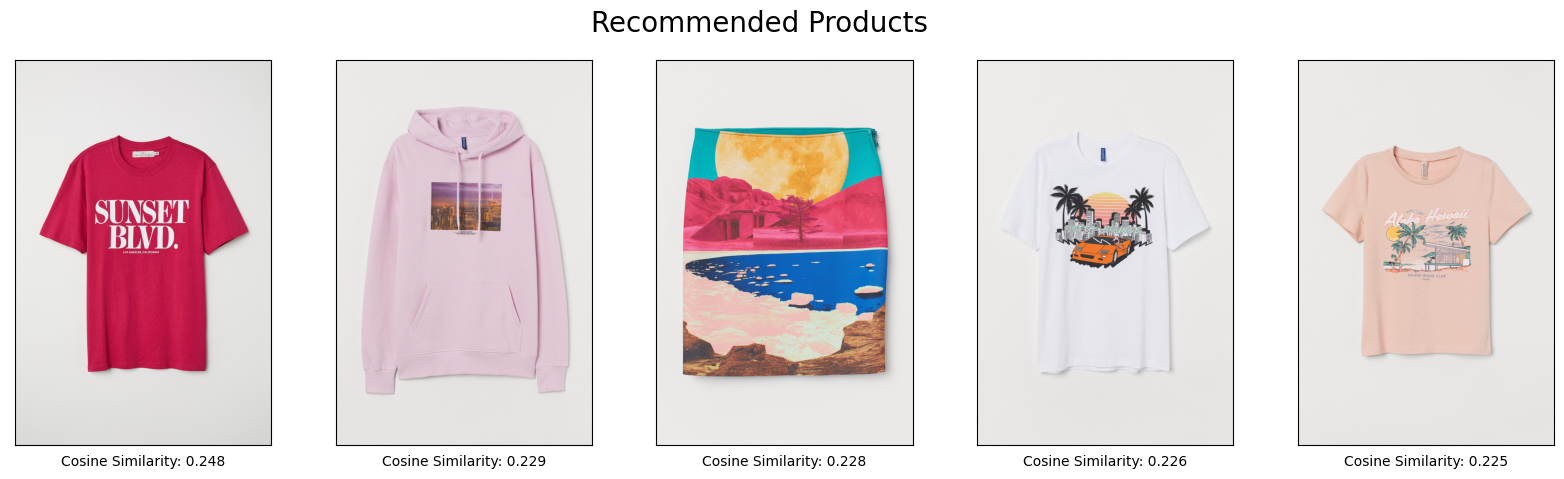

In [28]:
%time
text_query_recommender(df=image_data,text_query='sunset',number_of_recommendations=5)

In [32]:
# Define a recommender that receives image input
def image_query_recommender(df,image_query,number_of_recommendations):
    
    # Encode the image using CLIP
    image_emb = clip_model.encode([image_query])
    
    # Calculate cosine similarities for queried product
    similarities = cosine_similarity(image_emb,image_data['clip_embedding'].values.tolist())[0]
    
    # Sort cosine similarities in descending order, and select the top recommended product based on number of recommendations set
    k = number_of_recommendations+1
    similarities = pd.DataFrame(similarities,index=df['article_id'], columns=['cosine_sim']).sort_values(by='cosine_sim',ascending=False).iloc[1:k]
    
    # article_id of top recommended product
    nearest_articles_id = similarities.index.tolist()
    
    # Show image of queried product
    plt.imshow(image_query)
    plt.title("Queried Product",fontsize=20);
    plt.xticks([], [])
    plt.yticks([], []);
    
    # Show images of recommended product
    f, ax = plt.subplots(figsize=(20,5))
    plt.suptitle('Recommended Products',fontsize=20)
    
    i = 1
    for neighbor in nearest_articles_id:
        plt.subplot(1, len(nearest_articles_id), i)
        img = Image.open(df.loc[df['article_id'] == neighbor,'img_path'].values[0])
        plt.imshow(img)
        plt.xlabel(f"Cosine Similarity: {similarities.loc[neighbor].values[0]:.3f}")
        plt.xticks([], [])
        plt.yticks([], []);
        i+=1

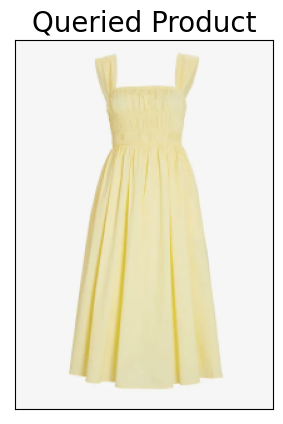

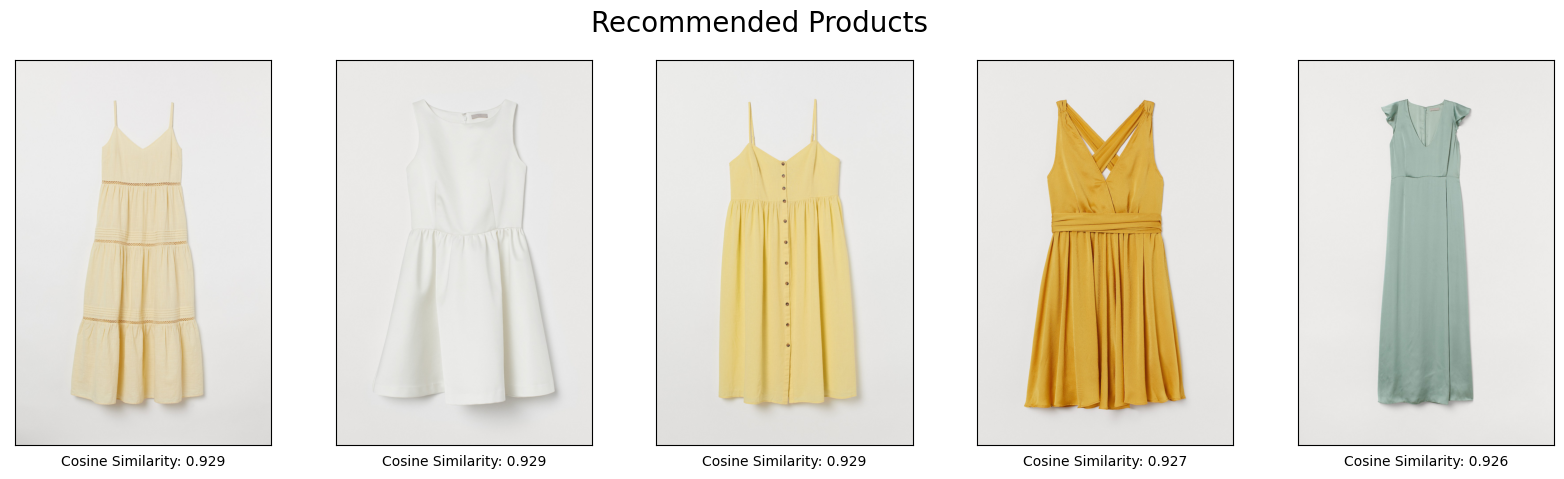

In [33]:
test_img_1 = Image.open('../datasets/test_images/test_image_1.png').reduce(2).convert('RGB')
image_query_recommender(df=image_data,image_query=test_img_1,number_of_recommendations=5)

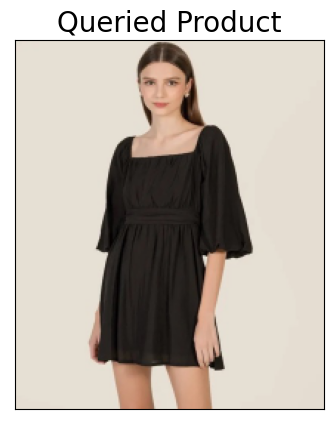

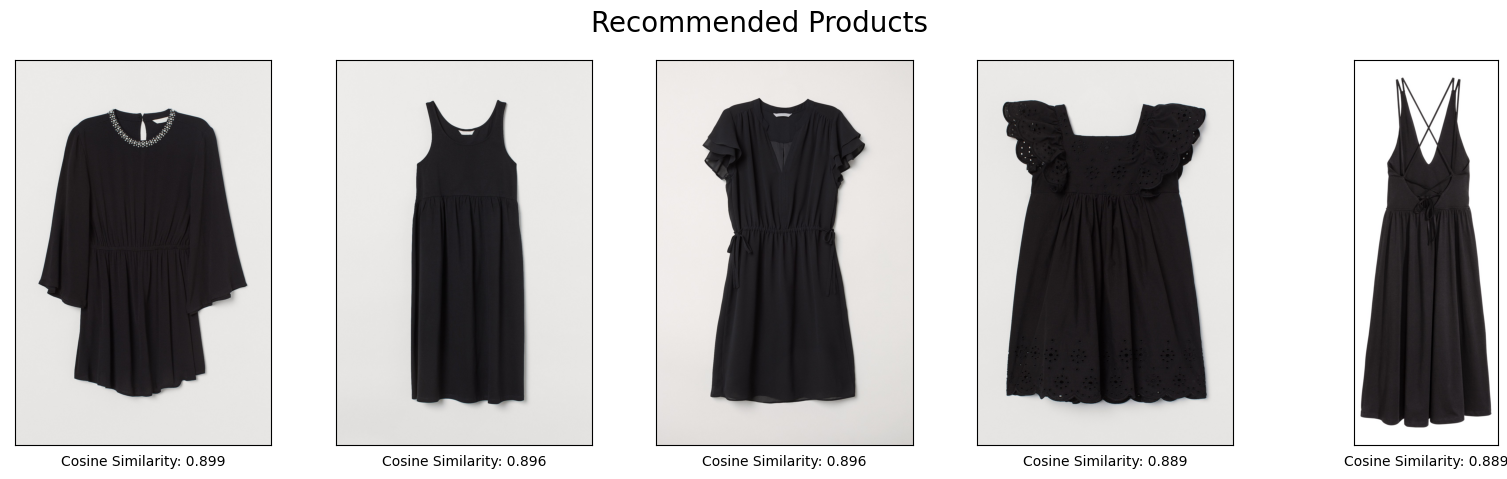

In [35]:
test_img_2 = Image.open('../datasets/test_images/test_image_2.jpg').reduce(2).convert('RGB')
image_query_recommender(df=image_data,image_query=test_img_2,number_of_recommendations=5)

## Summary

- The content-based recommender was built by extracting features from product images. 
- It supports both text and image query. When user inputs either text or image, the recommender was able to find similar images in the product dataset.
- Embeddings were generated from images using Contrastive Language-Image Pre-Training (CLIP) model, which is a state-of-the-art computer vision system that maps texts and images into the same shared vector space ([Radford et al., 2021](https://arxiv.org/abs/2103.00020)) to allow for multi-modal similarity search (for example, text-to-image, image-to-image).
- For each text or image query, similarity was computed using cosine similarity to find most similar items.